In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno

### Cargamos datos desde BigQuery

In [4]:
from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/louisboza/Documents/GitHub/JupyterX/ZeroGoki/BigQuery_Settings/jupyter-zero-42232e81c8c4.json'
%load_ext google.cloud.bigquery

In [5]:
QUERY = """
    SELECT *
    FROM `jupyter-zero.diplomado.AAPL_clean_2`
    # WHERE Fecha < '2020-02-02'
    # OR Fecha > '2020-06-04'
    """

df = pd.read_gbq(QUERY)
df['Date'] = df['Fecha']
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Fecha')
df = df.sort_index(ascending = True)
df['Return+1'] = df['Return'].shift(-1)
df.dropna(axis = 0, inplace = True)

#### Validamos la existencia de valores NA

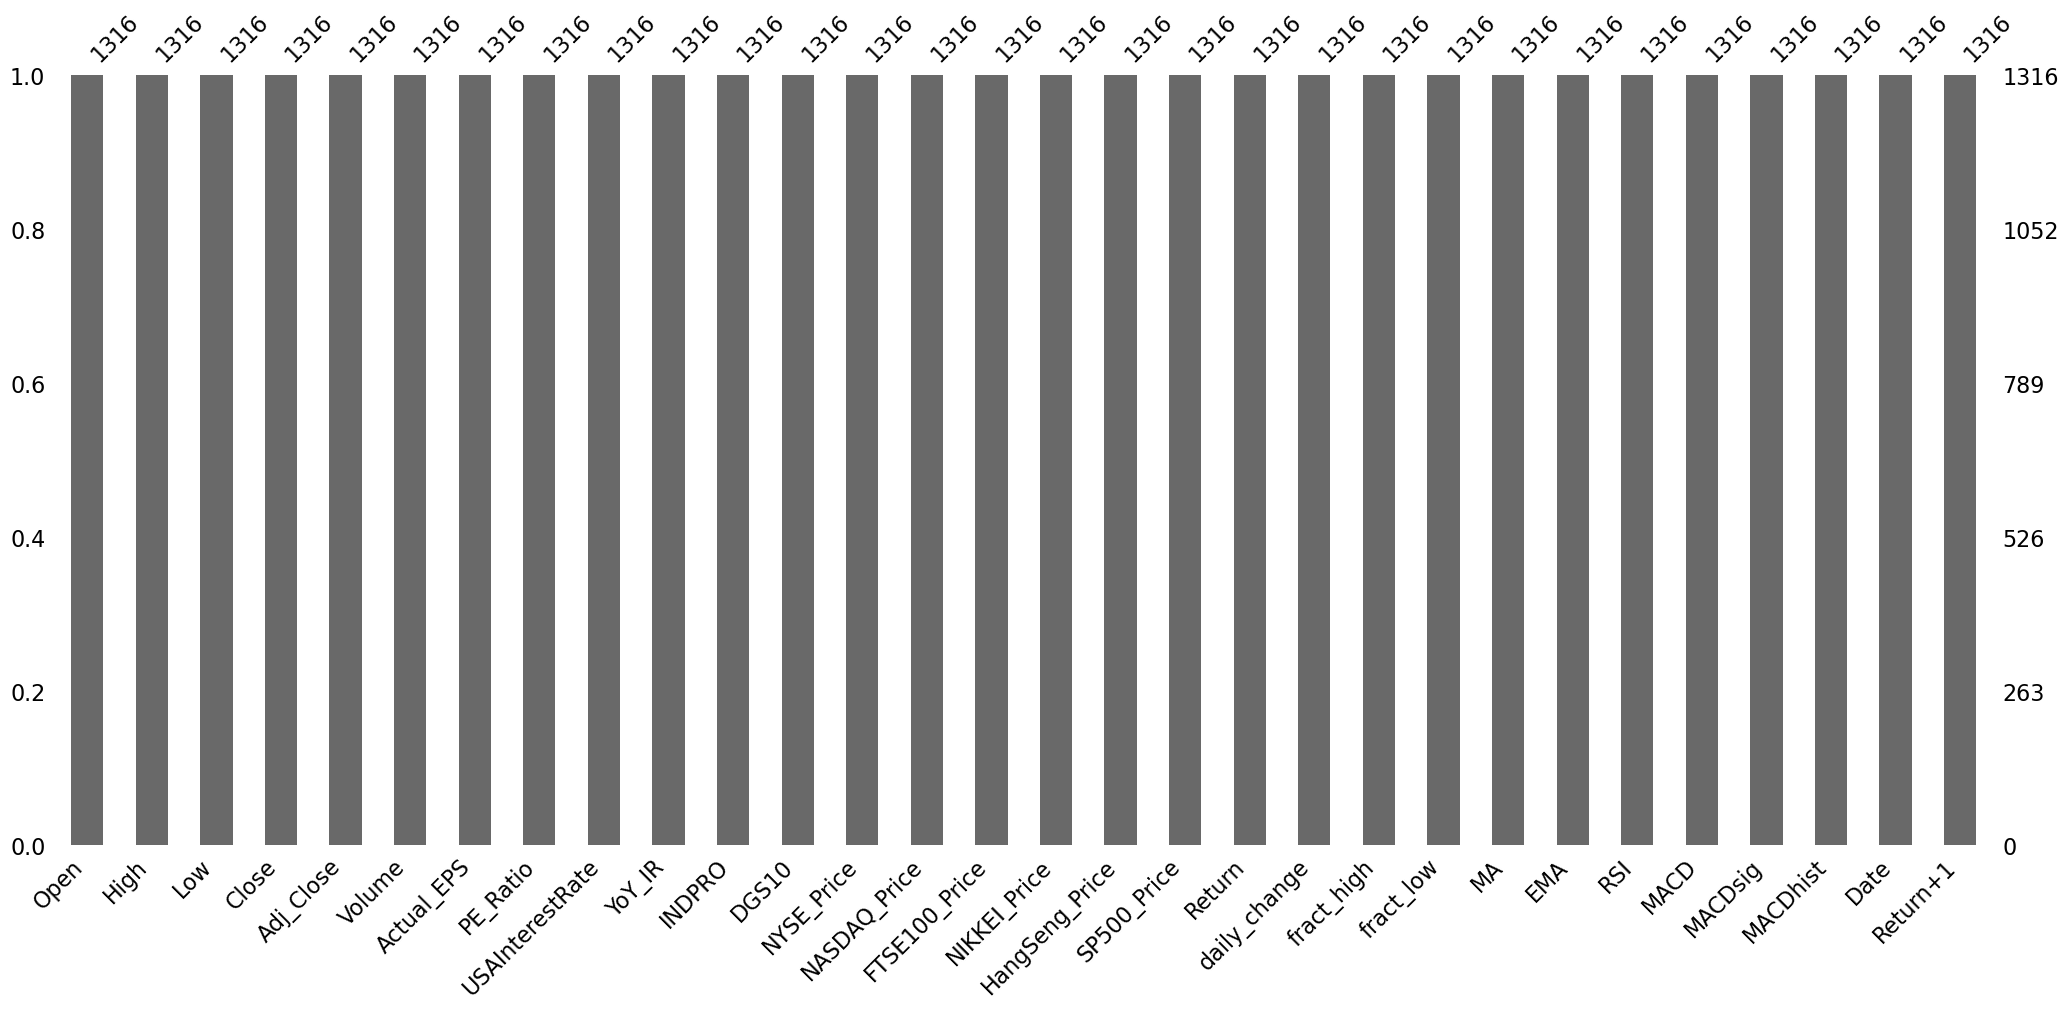

In [6]:
msno.bar(df);

#### Segmentación de variables de acuerdo a su naturaleza

* internos: 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'
* Técnicos: 'Return', 'Return+1', 'daily_change', 'fract_high', 'fract_low', 'MA', 'EMA', 'RSI', 'MACD', 'MACDsig', 'MACDhist'
* Fundamental: 'Actual_EPS', 'PE_Ratio'
* Economicos: 'USAInterestRate', 'YoY_IR', 'INDPRO', 'DGS10'
* Benchmark: 'NYSE_Price', 'NASDAQ_Price', 'FTSE100_Price', 'NIKKEI_Price', 'HangSeng_Price', 'SP500_Price'

### Parte 1: Chunck DF

* Se crea un dataframe genetal, el cual se conforma de subdataset los cuales tienen una ventana de 180 dias.
* Se entrena cada uno de esos chuncks para ver si el modelo logra categorizar las subidas y bajadas con la misma efectividad que con toda la muestra.

In [72]:
quotes = []
n = 0
for index, row in df.iterrows():
    row_quant = 200
    row_start = n
    subset = df.iloc[row_start: row_start + row_quant]
    #print(subset)
    n =+ n + 1

    close_date = max(subset['Date'])
    print(close_date)

    #internos: 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'
    #Técnicos: 'Return', 'Return+1', 'daily_change', 'fract_high', 'fract_low', 'MA', 'EMA', 'RSI', 'MACD', 'MACDsig', 'MACDhist'
    #Fundamental: 'Actual_EPS', 'PE_Ratio'
    #Economicos: 'USAInterestRate', 'YoY_IR', 'INDPRO', 'DGS10'
    #Benchmark: 'NYSE_Price', 'NASDAQ_Price', 'FTSE100_Price', 'NIKKEI_Price', 'HangSeng_Price', 'SP500_Price'

    if len(subset) == 200:

        # X = subset[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume',
        #             'PE_Ratio', 
        #             'fract_high', 'fract_low', 'MA', 'EMA', 'RSI', 'MACD']]

        X = subset[['Return']].values.reshape(-1,1)


        # X = subset[['Adj_Close', 'USAInterestRate', 'YoY_IR', 'INDPRO', 'DGS10',
        #             'NYSE_Price', 'NASDAQ_Price', 'NIKKEI_Price', 'HangSeng_Price', 'SP500_Price']]

        from sklearn.preprocessing import StandardScaler
        ss =  StandardScaler().fit(X)
        X_Scaled = ss.transform(X)

        from sklearn.decomposition import PCA
        pca = PCA(n_components = 1)
        pca.fit(X_Scaled)
        X_pca = pca.transform(X_Scaled)
        
        from sklearn.mixture import GaussianMixture
        gmm = GaussianMixture(n_components = 4, covariance_type = 'full', random_state = 2023).fit(X_pca)
        labels = gmm.predict(X_pca)

        # HMM_Model = GaussianHMM(n_components = 4, covariance_type = 'full', n_iter = 1000000, random_state = 2023).fit(X_pca)
        # labels = HMM_Model.predict(X_pca)

        quotes.append(pd.DataFrame({'Secuence ID':[n] * len(subset),
                                    'close_date':[close_date] * len(subset),
                                    'Date':subset['Date'],
                                    'Open':subset['Open'],
                                    'High':subset['High'],
                                    'Low':subset['Low'],
                                    'Close':subset['Close'],
                                    'Adj_Close':subset['Adj_Close'],
                                    'Volume':subset['Volume'],
                                    'Actual_EPS':subset['Actual_EPS'],
                                    'PE_Ratio':subset['PE_Ratio'],
                                    'USAInterestRate':subset['USAInterestRate'],
                                    'YoY_IR':subset['YoY_IR'],
                                    'INDPRO':subset['INDPRO'],
                                    'DGS10':subset['DGS10'],
                                    'NYSE_Price':subset['NYSE_Price'],
                                    'NASDAQ_Price':subset['NASDAQ_Price'],
                                    'FTSE100_Price':subset['FTSE100_Price'],
                                    'NIKKEI_Price':subset['NIKKEI_Price'],
                                    'HangSeng_Price':subset['HangSeng_Price'],
                                    'SP500_Price':subset['SP500_Price'],
                                    'Return':subset['Return'],
                                    'Return+1':subset['Return+1'],
                                    'daily_change':subset['daily_change'],
                                    'fract_high':subset['fract_high'],
                                    'fract_low':subset['fract_low'],
                                    'MA':subset['MA'],
                                    'EMA':subset['EMA'],
                                    'RSI':subset['RSI'],
                                    'MACD':subset['MACD'],
                                    'MACDsig':subset['MACDsig'],
                                    'MACDhist':subset['MACDhist'],
                                    'labels': labels
                                    }))
    else:
        pass

quotes_df = pd.concat(quotes)
quotes_df.shape

2017-12-08 00:00:00
2017-12-11 00:00:00
2017-12-12 00:00:00
2017-12-13 00:00:00
2017-12-14 00:00:00
2017-12-15 00:00:00
2017-12-18 00:00:00
2017-12-19 00:00:00
2017-12-20 00:00:00
2017-12-21 00:00:00
2017-12-22 00:00:00
2017-12-27 00:00:00
2017-12-28 00:00:00
2017-12-29 00:00:00
2018-01-04 00:00:00
2018-01-05 00:00:00
2018-01-09 00:00:00
2018-01-10 00:00:00
2018-01-11 00:00:00
2018-01-12 00:00:00
2018-01-16 00:00:00
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-20 00:00:00
2018-02-21 00:00:00
2018-02-22 00:00:00
2018-02-23 00:00:00
2018-02-26 00:00:00
2018-02-27 00:00:00
2018-02-28 00:00:00
2018-03-01 00:00:00


(223400, 33)

In [73]:
quotes_df

quotes_df.groupby(['Secuence ID', 'close_date']).size()

Secuence ID  close_date
1            2017-12-08    200
2            2017-12-11    200
3            2017-12-12    200
4            2017-12-13    200
5            2017-12-14    200
                          ... 
1113         2022-12-21    200
1114         2022-12-22    200
1115         2022-12-23    200
1116         2022-12-28    200
1117         2022-12-29    200
Length: 1117, dtype: int64

Se crearon 1137 chuncks se 180 dias cada uno.

''

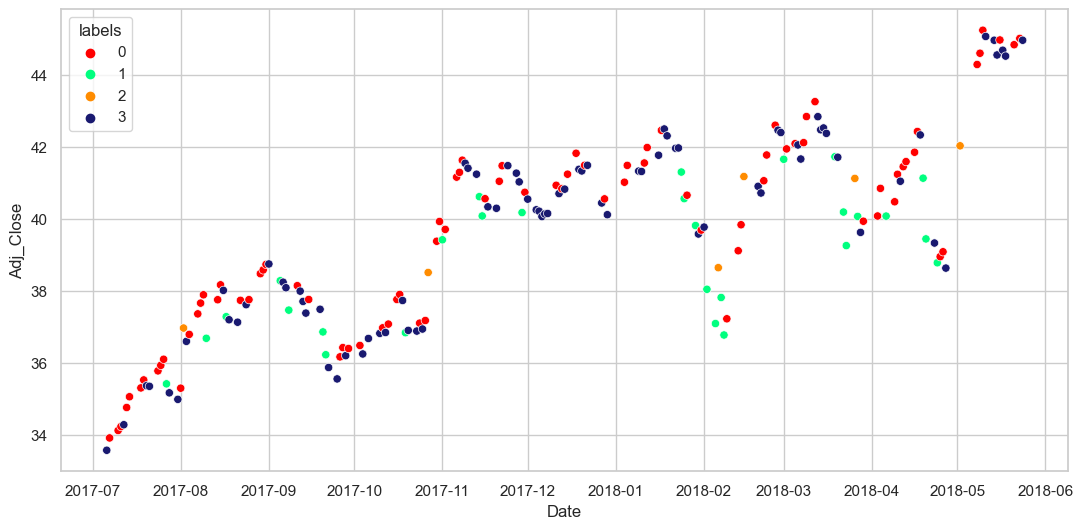

In [74]:
df1 = quotes_df[quotes_df['Secuence ID'] == 100]

sns.set(style='whitegrid')
 
plt.figure(figsize=(13, 6), dpi = 100)
sns.scatterplot(x = df1.iloc[:, 2],
                y = df1.iloc[:, 7],
                hue = df1['labels'],
                palette = {0: 'red', 1: 'springgreen', 2: 'darkorange', 3: 'midnightblue'}
)
;

''

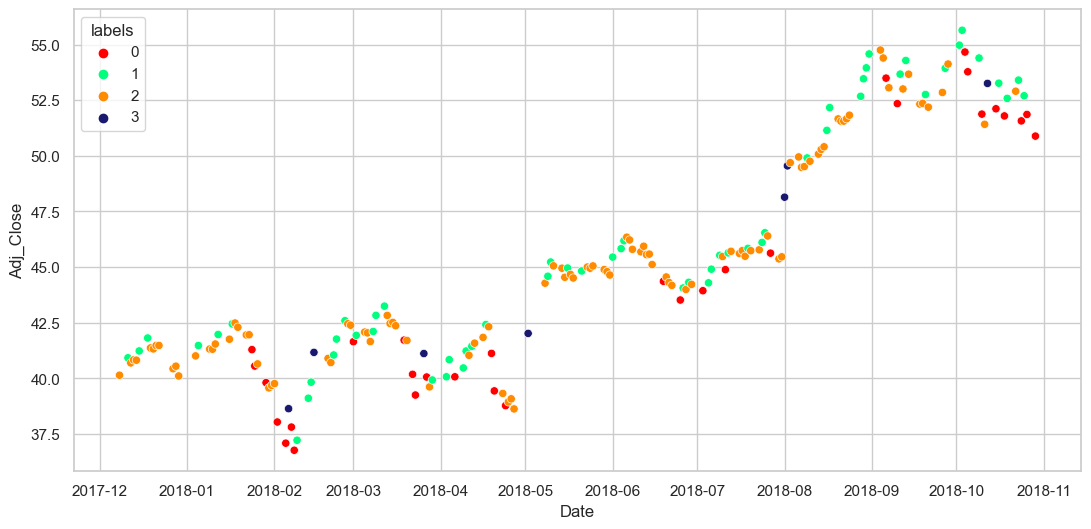

In [75]:
df2 = quotes_df[quotes_df['Secuence ID'] == 200]

sns.set(style='whitegrid')
 
plt.figure(figsize=(13, 6), dpi = 100)
sns.scatterplot(x = df2.iloc[:, 2],
                y = df2.iloc[:, 7],
                hue = df2['labels'],
                palette = {0: 'red', 1: 'springgreen', 2: 'darkorange', 3: 'midnightblue'}
)
;

In [80]:
df2.groupby(['labels'])['Return'].agg(["mean", "median", "var"])

,mean,median,var
labels,,,
0,-0.021880,-0.017851,0.000078
1,0.012952,0.011554,0.000025
2,-0.001828,-0.001464,0.000025
3,0.041554,0.041792,0.000099


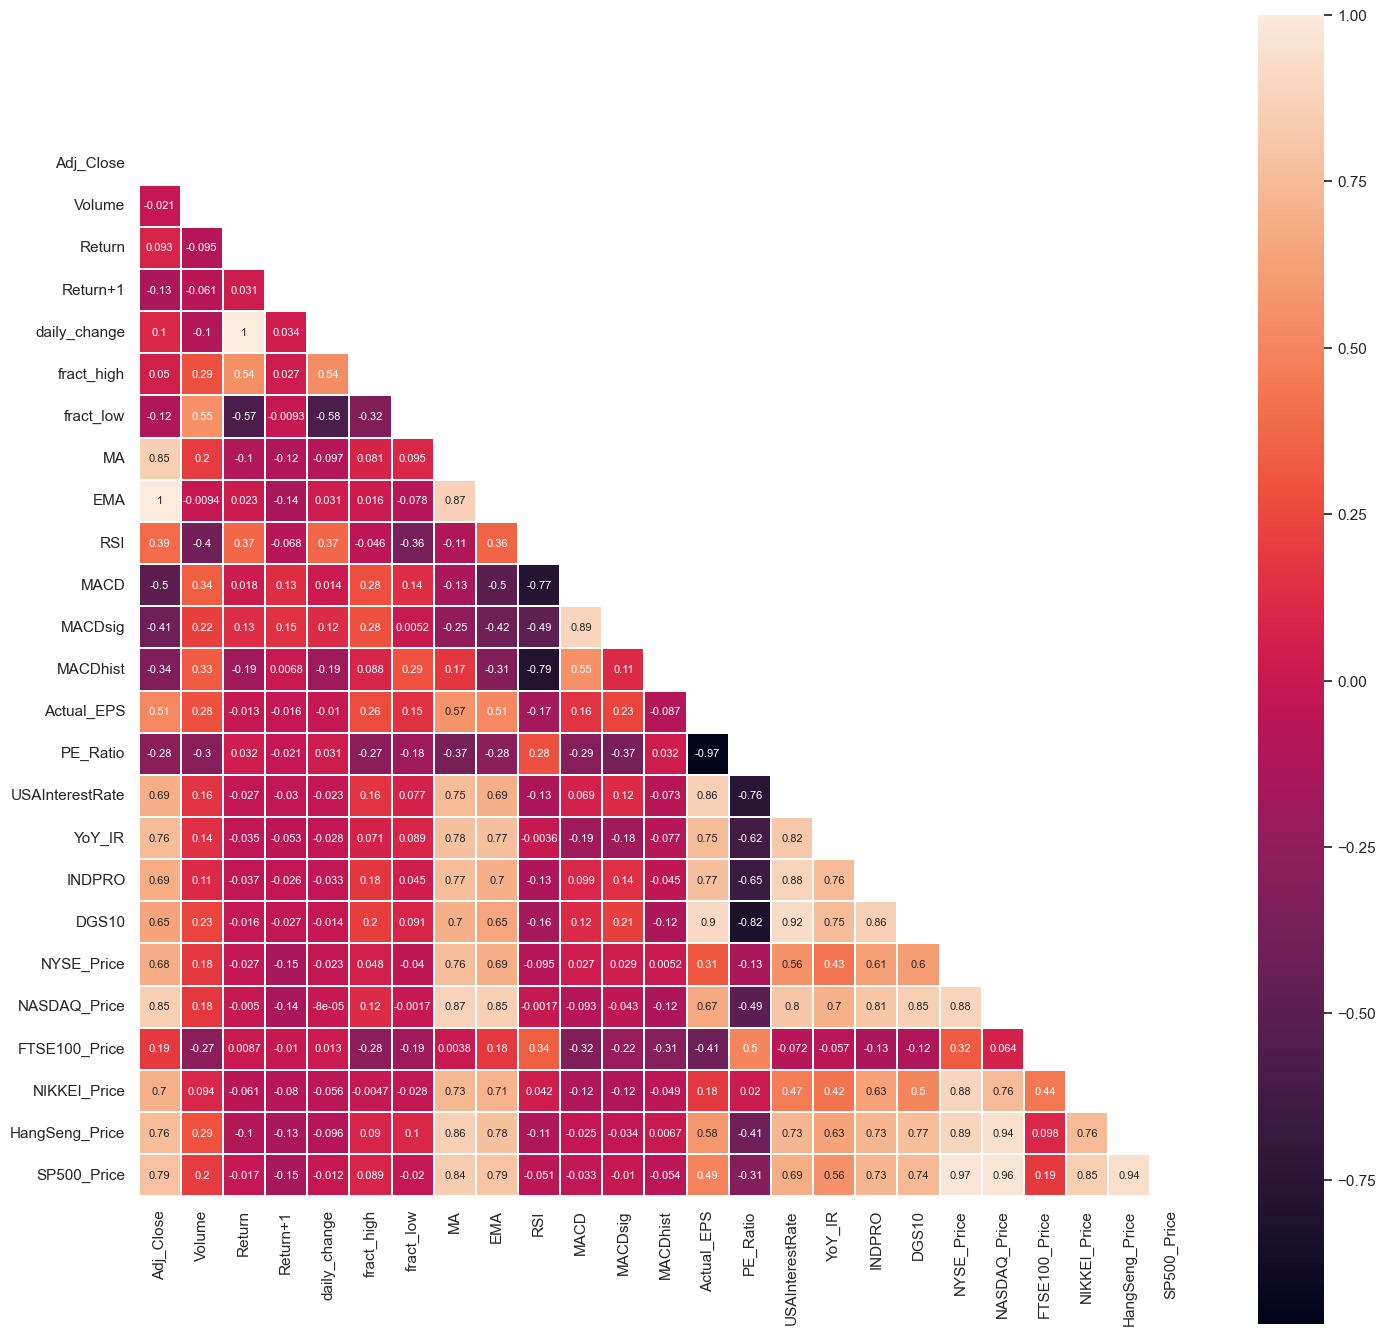

In [77]:
#internos: 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'
#Técnicos: 'Return', 'Return+1', 'daily_change', 'fract_high', 'fract_low', 'MA', 'EMA', 'RSI', 'MACD', 'MACDsig', 'MACDhist'
#Fundamental: 'Actual_EPS', 'PE_Ratio'
#Economicos: 'USAInterestRate', 'YoY_IR', 'INDPRO', 'DGS10'
#Benchmark: 'NYSE_Price', 'NASDAQ_Price', 'FTSE100_Price', 'NIKKEI_Price', 'HangSeng_Price', 'SP500_Price'

corrdf = df1[['Adj_Close', 'Volume', 
              'Return', 'Return+1', 'daily_change', 'fract_high', 'fract_low', 'MA', 'EMA', 'RSI', 'MACD', 'MACDsig', 'MACDhist',
              'Actual_EPS', 'PE_Ratio',
              'USAInterestRate', 'YoY_IR', 'INDPRO', 'DGS10',
              'NYSE_Price', 'NASDAQ_Price', 'FTSE100_Price', 'NIKKEI_Price', 'HangSeng_Price', 'SP500_Price']]
correlation_mat = corrdf.corr()

matrix = np.triu(correlation_mat)

plt.figure(figsize=(17, 17))
sns.heatmap(correlation_mat, vmin=correlation_mat.values.min(), vmax=1, square=True, 
            linewidths=0.1, annot=True, annot_kws={"size":8}, mask=matrix)
plt.show()

In [79]:
df1[['Date', 'Adj_Close', 'Return']]

,Date,Adj_Close,Return
Fecha,,,
2017-07-06,2017-07-06,33.578896,-0.009438
2017-07-07,2017-07-07,33.920033,0.010159
2017-07-10,2017-07-10,34.127071,0.006104
2017-07-11,2017-07-11,34.237640,0.003240
2017-07-12,2017-07-12,34.287045,0.001443
...,...,...,...
2018-05-17,2018-05-17,44.675438,-0.006323
2018-05-18,2018-05-18,44.512966,-0.003637
2018-05-21,2018-05-21,44.828339,0.007085
